In [ ]:
import kagglehub

path = kagglehub.dataset_download("sabarinathan/istd-dataset")
print("Dataset downloaded to:", path)


100%|██████████| 2.00G/2.00G [00:23<00:00, 91.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1


In [ ]:
import os

for root, dirs, files in os.walk(path):
    print(root)


/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/test
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/test/test_B
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/test/test_C
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/test/test_A
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/train
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/train/train_C
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/train/train_B
/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset/train/train_A


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.fc(self.avg_pool(x))
        max_ = self.fc(self.max_pool(x))
        return self.sigmoid(avg + max_)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, max_], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CrossDomainAttention(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.ca = ChannelAttention(in_ch)
        self.sa = SpatialAttention()

    def forward(self, rgb, mask):
        #  Resize mask to match feature map (H, W)
        mask = F.interpolate(mask, size=rgb.shape[2:], mode='bilinear', align_corners=False)

        # Expand channel to match feature map (C)
        if mask.shape[1] == 1:
            mask = mask.repeat(1, rgb.shape[1], 1, 1)

        # Fuse features
        fused = rgb + mask
        return fused * self.ca(fused) * self.sa(fused)


In [ ]:
#Cdafn
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class CDAFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.cross_attn = CrossDomainAttention(256)

        self.dec3 = ConvBlock(256, 128)
        self.dec2 = ConvBlock(128, 64)
        self.dec1 = ConvBlock(64, 3)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, mask):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        fused = self.cross_attn(e3, mask)

        d3 = self.up(self.dec3(fused))
        d2 = self.up(self.dec2(d3))
        out = self.dec1(d2)
        return out


In [ ]:
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class ISTDDataset(Dataset):
    def __init__(self, root, mode="train"):
        self.root = root
        self.mode = mode

        if mode == "train":
            self.shadow_dir = os.path.join(root, "train", "train_A")
            self.gt_dir = os.path.join(root, "train", "train_B")
            self.mask_dir = os.path.join(root, "train", "train_C")
        else:
            self.shadow_dir = os.path.join(root, "test", "test_A")
            self.gt_dir = os.path.join(root, "test", "test_B")
            self.mask_dir = os.path.join(root, "test", "test_C")

        self.filenames = sorted(os.listdir(self.shadow_dir))

        self.to_tensor = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        shadow = Image.open(os.path.join(self.shadow_dir, fname)).convert("RGB")
        gt = Image.open(os.path.join(self.gt_dir, fname)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, fname)).convert("L")

        return {
            "input": self.to_tensor(shadow),
            "gt": self.to_tensor(gt),
            "mask": self.to_tensor(mask)
        }

    def __len__(self):
        return len(self.filenames)


In [ ]:
import torch.optim as optim
import torch.nn as nn
import os

#Override dataset_path inside this cell ONLY
dataset_path = "/root/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1/ISTD_Dataset"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device:", device)

# Initialize model
model = CDAFN().to(device)

# Load dataset
train_dataset = ISTDDataset(dataset_path, mode="train")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(2):   #I run it for 30,50,70 epochs but I took 50 for results as I found it better. before submitting the code I just run it for 2 epochs to check either it is working perfectly or not
    model.train()
    total_loss = 0
    for batch in train_loader:
        x = batch["input"].to(device)
        y = batch["gt"].to(device)
        mask = batch["mask"].to(device)

        optimizer.zero_grad()
        pred = model(x, mask)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), "cdafn.pth")
print("Model saved as cdafn.pth")


 Using device: cuda
Epoch 1: Loss = 0.0613
Epoch 2: Loss = 0.0243
Model saved as cdafn.pth


In [ ]:
!pip install piq --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00


Downloading: "https://github.com/photosynthesis-team/photosynthesis.metrics/releases/download/v0.4.0/lpips_weights.pt" to /root/.cache/torch/hub/checkpoints/lpips_weights.pt
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


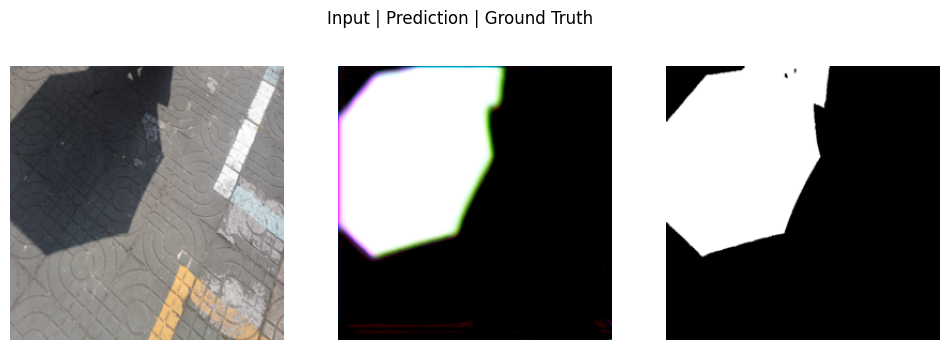

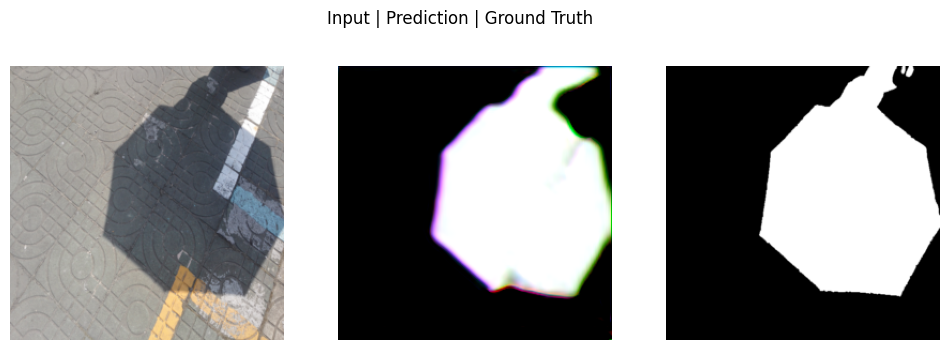

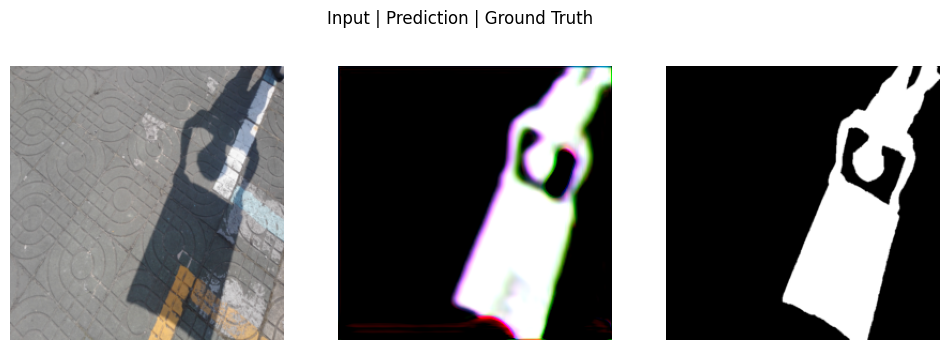

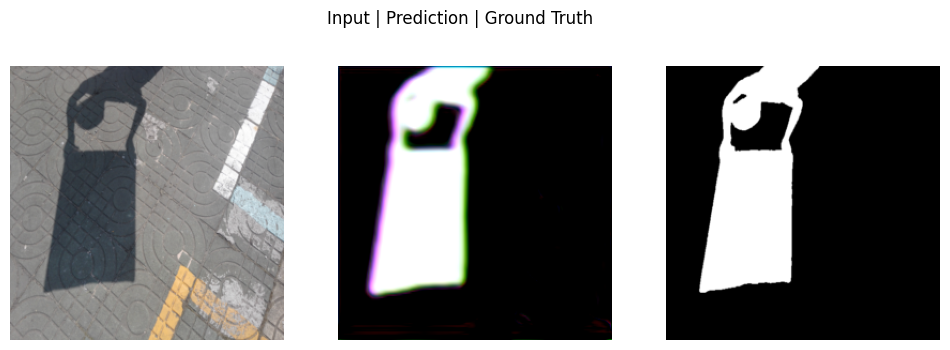

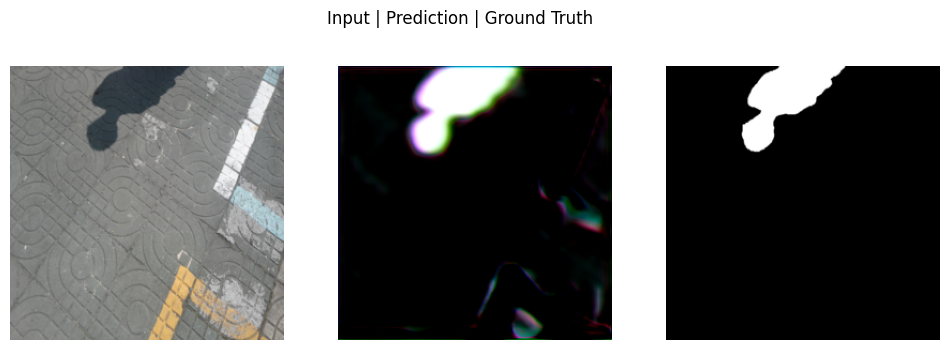

 CDAFN Evaluation:
PSNR: 18.80, SSIM: 0.81, LPIPS: 0.30
Precision: 0.85, Recall: 0.97, F1 Score: 0.89


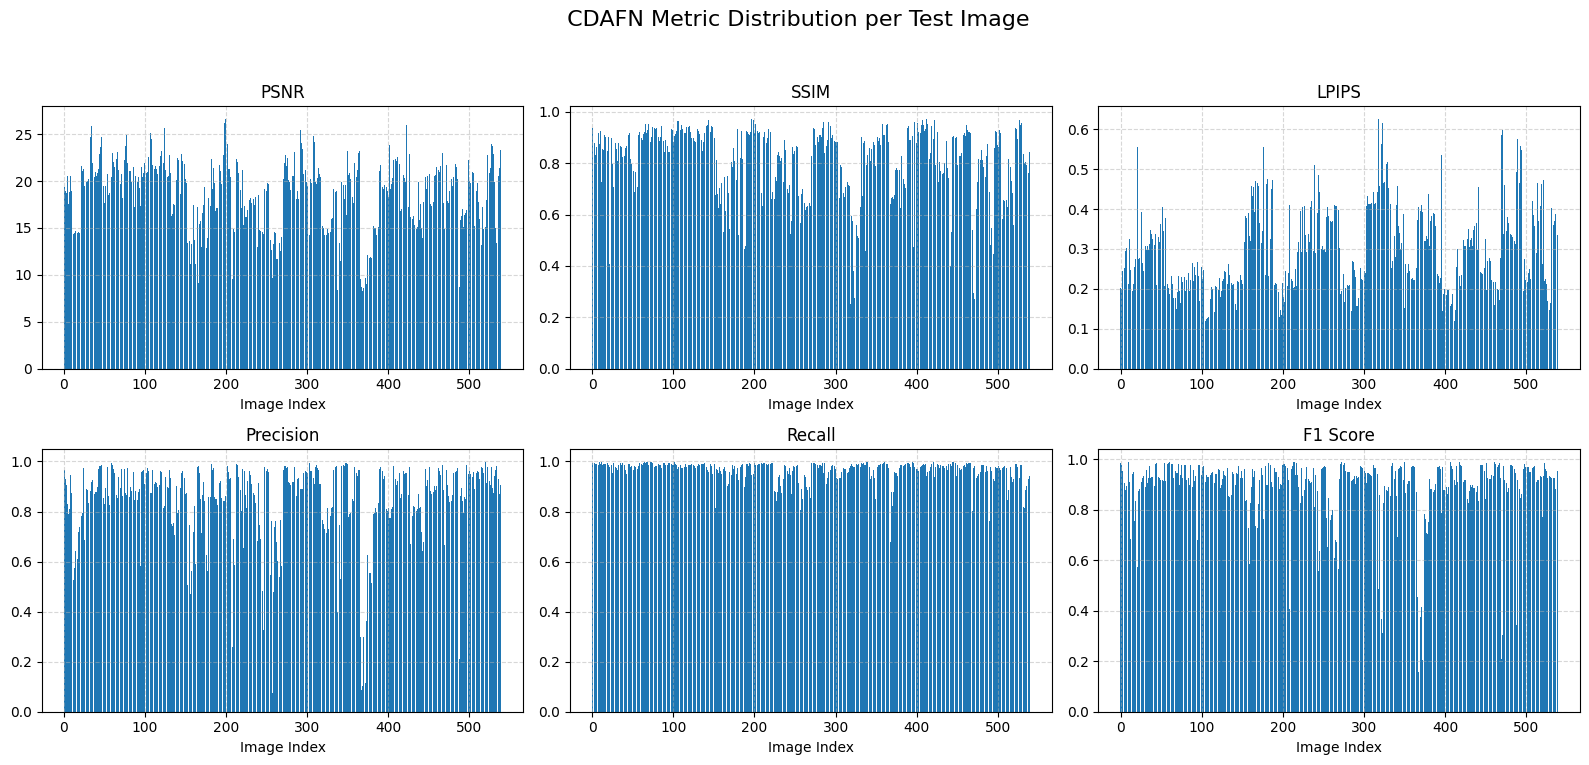

In [ ]:
import torch
from piq import psnr, ssim, LPIPS
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_metric = LPIPS().to(device)

def get_f1(pred, gt):
    pred_bin = (pred > 0.5).float()
    gt_bin = (gt > 0.5).float()
    tp = (pred_bin * gt_bin).sum()
    fp = (pred_bin * (1 - gt_bin)).sum()
    fn = ((1 - pred_bin) * gt_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return precision.item(), recall.item(), f1.item()

def visualize(x, pred, gt, idx):
    inp = x.squeeze().permute(1, 2, 0).cpu().numpy()
    out = pred.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    truth = gt.squeeze().permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(12, 4))
    for i, img in enumerate([inp, out, truth]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle("Input | Prediction | Ground Truth")
    plt.savefig(f"cdafn_result_{idx}.png")
    plt.show()

# Evaluation
model = CDAFN().to(device)
model.load_state_dict(torch.load("cdafn.pth", map_location=device))  # Load trained model weights
model.eval()
test_dataset = ISTDDataset(dataset_path, mode="test")
test_loader = DataLoader(test_dataset, batch_size=1)

psnr_list, ssim_list, lpips_list = [], [], []
precision_list, recall_list, f1_list = [], [], []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        try:
            x = batch["input"].to(device)
            y = batch["gt"].to(device)
            mask = batch["mask"].to(device)

            out = model(x, mask)
            out = torch.clamp(out, 0.0, 1.0)

            psnr_list.append(psnr(out, y).item())
            ssim_list.append(ssim(out, y).item())
            lpips_list.append(lpips_metric(out, y).item())
            prec, rec, f1 = get_f1(out, y)
            precision_list.append(prec)
            recall_list.append(rec)
            f1_list.append(f1)

            if i < 5:
                visualize(x, out, y, i)

        except Exception as e:
            print(f" Error at index {i}: {e}")


# Averages
print(" CDAFN Evaluation:")
print(f"PSNR: {sum(psnr_list)/len(psnr_list):.2f}, SSIM: {sum(ssim_list)/len(ssim_list):.2f}, LPIPS: {sum(lpips_list)/len(lpips_list):.2f}")
print(f"Precision: {sum(precision_list)/len(precision_list):.2f}, Recall: {sum(recall_list)/len(recall_list):.2f}, F1 Score: {sum(f1_list)/len(f1_list):.2f}")

# Bar Charts
image_indices = np.arange(len(psnr_list))
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle(" CDAFN Metric Distribution per Test Image", fontsize=16)

axs[0, 0].bar(image_indices, psnr_list)
axs[0, 0].set_title("PSNR")
axs[0, 1].bar(image_indices, ssim_list)
axs[0, 1].set_title("SSIM")
axs[0, 2].bar(image_indices, lpips_list)
axs[0, 2].set_title("LPIPS")
axs[1, 0].bar(image_indices, precision_list)
axs[1, 0].set_title("Precision")
axs[1, 1].bar(image_indices, recall_list)
axs[1, 1].set_title("Recall")
axs[1, 2].bar(image_indices, f1_list)
axs[1, 2].set_title("F1 Score")

for ax in axs.flat:
    ax.set_xlabel("Image Index")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
#Save all metrics to CSV for analysis
import pandas as pd

df = pd.DataFrame({
    "Image Index": image_indices,
    "PSNR": psnr_list,
    "SSIM": ssim_list,
    "LPIPS": lpips_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_list
})

df.to_csv("cdafn_metrics.csv", index=False)
print("Metrics saved to cdafn_metrics.csv")


Metrics saved to cdafn_metrics.csv


In [ ]:
#Download the CSV file
from google.colab import files
files.download("cdafn_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#U-Net architecture
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.dec3 = self.conv_block(256, 128)
        self.dec2 = self.conv_block(128, 64)
        self.dec1 = self.conv_block(64, 3)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),   # Added BatchNorm
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),   # Added BatchNorm
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d3 = self.up(self.dec3(e3))
        d2 = self.up(self.dec2(d3))
        out = self.dec1(d2)  # Final output matches 256×256 GT
        return out


In [ ]:
#Train U-Net Baseline Model on ISTD Dataset
unet = UNet().to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_loader = DataLoader(ISTDDataset(dataset_path, "train"), batch_size=4, shuffle=True)

print(" Training U-Net...")
for epoch in range(2): #Explained in CDAFN I added 50 epochs result in the report but for final submission I just use 2 epochs
    unet.train()
    total_loss = 0
    for batch in train_loader:
        x = batch["input"].to(device)
        y = batch["gt"].to(device)

        optimizer.zero_grad()
        pred = unet(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: U-Net Loss = {total_loss/len(train_loader):.4f}")

torch.save(unet.state_dict(), "unet.pth")
print(" U-Net model saved as unet.pth")


 Training U-Net...
Epoch 1: U-Net Loss = 0.0836
Epoch 2: U-Net Loss = 0.0566
 U-Net model saved as unet.pth


Evaluating U-Net...


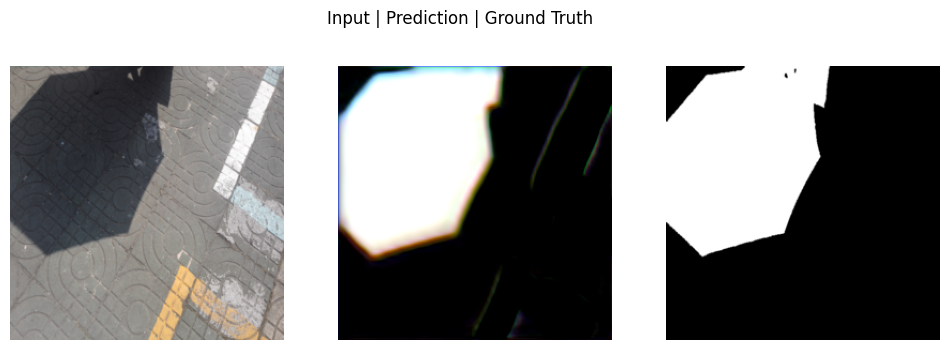

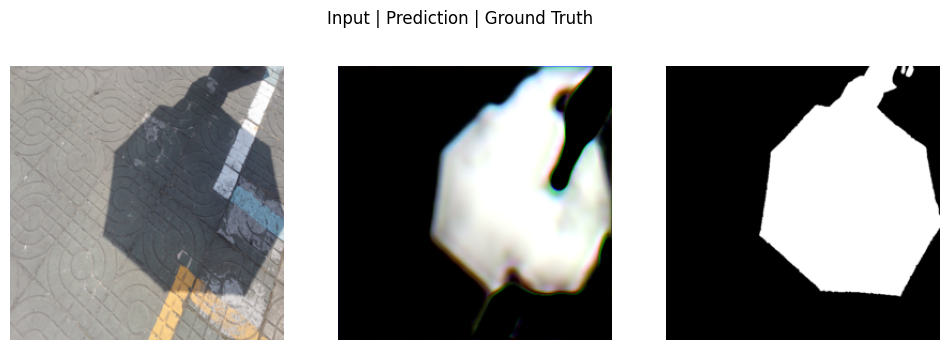

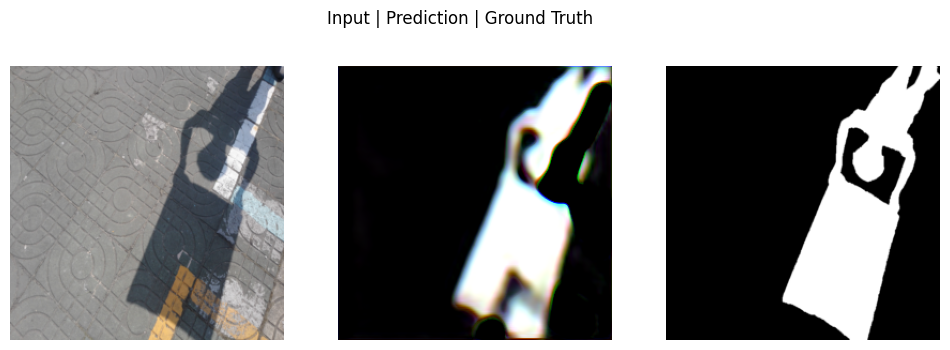

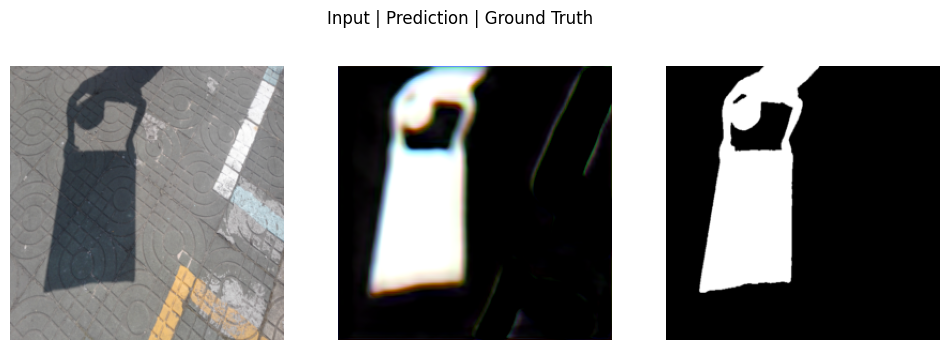

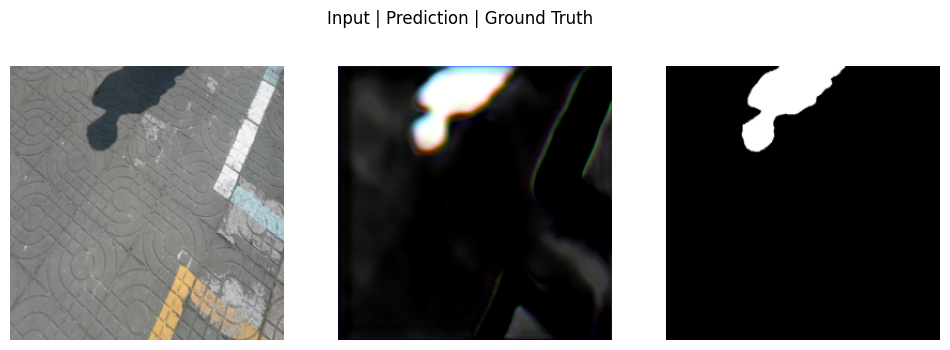

 U-Net Evaluation:
PSNR: 15.54, SSIM: 0.66, LPIPS: 0.35
Precision: 0.80, Recall: 0.75, F1 Score: 0.74


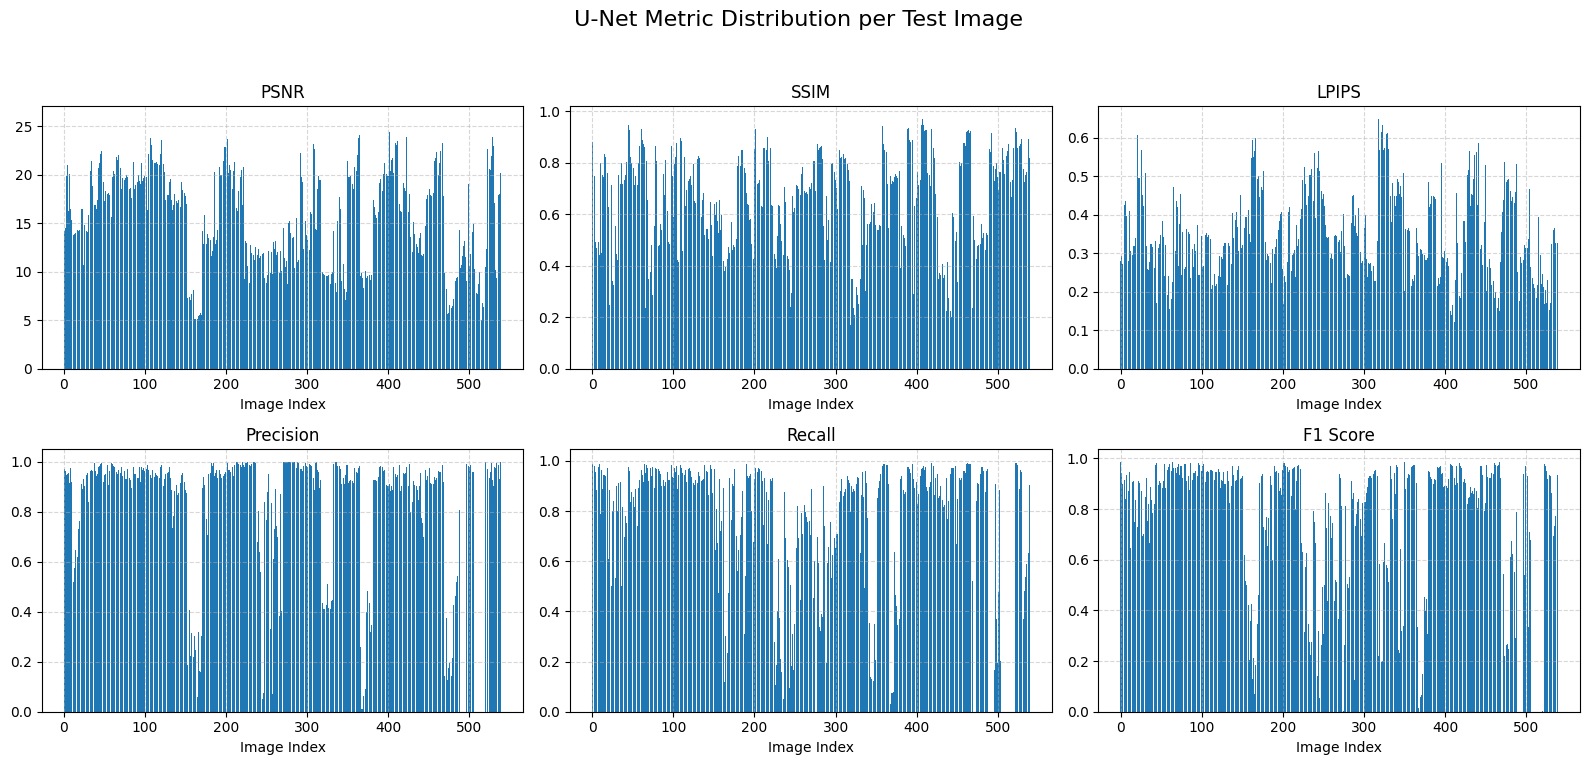

In [ ]:
#Evaluate Trained U-Net on Test Set
print("Evaluating U-Net...")

unet = UNet().to(device)
unet.load_state_dict(torch.load("unet.pth", map_location=device))
unet.eval()
test_loader = DataLoader(ISTDDataset(dataset_path, "test"), batch_size=1)

psnr_list, ssim_list, lpips_list = [], [], []
precision_list, recall_list, f1_list = [], [], []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x = batch["input"].to(device)
        y = batch["gt"].to(device)

        out = unet(x)
        out = torch.clamp(out, 0.0, 1.0)

        psnr_list.append(psnr(out, y).item())
        ssim_list.append(ssim(out, y).item())
        lpips_list.append(lpips_metric(out, y).item())
        prec, rec, f1 = get_f1(out, y)
        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)

        if i < 5:
            visualize(x, out, y, f"unet_{i}")

# Averages
print(" U-Net Evaluation:")
print(f"PSNR: {sum(psnr_list)/len(psnr_list):.2f}, SSIM: {sum(ssim_list)/len(ssim_list):.2f}, LPIPS: {sum(lpips_list)/len(lpips_list):.2f}")
print(f"Precision: {sum(precision_list)/len(precision_list):.2f}, Recall: {sum(recall_list)/len(recall_list):.2f}, F1 Score: {sum(f1_list)/len(f1_list):.2f}")

# Bar Charts
image_indices = np.arange(len(psnr_list))
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle(" U-Net Metric Distribution per Test Image", fontsize=16)

axs[0, 0].bar(image_indices, psnr_list)
axs[0, 0].set_title("PSNR")
axs[0, 1].bar(image_indices, ssim_list)
axs[0, 1].set_title("SSIM")
axs[0, 2].bar(image_indices, lpips_list)
axs[0, 2].set_title("LPIPS")
axs[1, 0].bar(image_indices, precision_list)
axs[1, 0].set_title("Precision")
axs[1, 1].bar(image_indices, recall_list)
axs[1, 1].set_title("Recall")
axs[1, 2].bar(image_indices, f1_list)
axs[1, 2].set_title("F1 Score")

for ax in axs.flat:
    ax.set_xlabel("Image Index")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
#Save all metrics to CSV for analysis for U-Net
import pandas as pd

df_unet = pd.DataFrame({
    "Image Index": image_indices,
    "PSNR": psnr_list,
    "SSIM": ssim_list,
    "LPIPS": lpips_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_list
})

df_unet.to_csv("unet_metrics.csv", index=False)
print("U-Net metrics saved to unet_metrics.csv")


U-Net metrics saved to unet_metrics.csv


In [ ]:
#Download U-Net csv file
from google.colab import files
files.download("unet_metrics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Combine csv of cdafn and unet
import pandas as pd

# Load both CSVs
cdafn_df = pd.read_csv("cdafn_metrics.csv")
unet_df = pd.read_csv("unet_metrics.csv")

# Rename columns in unet_df for clarity
unet_df = unet_df.rename(columns={
    "PSNR": "PSNR_U-Net",
    "SSIM": "SSIM_U-Net",
    "LPIPS": "LPIPS_U-Net",
    "Precision": "Precision_U-Net",
    "Recall": "Recall_U-Net",
    "F1 Score": "F1_U-Net"
})

cdafn_df = cdafn_df.rename(columns={
    "PSNR": "PSNR_CDAFN",
    "SSIM": "SSIM_CDAFN",
    "LPIPS": "LPIPS_CDAFN",
    "Precision": "Precision_CDAFN",
    "Recall": "Recall_CDAFN",
    "F1 Score": "F1_CDAFN"
})

# Merge on Image Index
comparison_df = pd.merge(cdafn_df, unet_df, on="Image Index")

# Save to CSV
comparison_df.to_csv("model_comparison_metrics.csv", index=False)
print("Combined comparison saved as model_comparison_metrics.csv")


Combined comparison saved as model_comparison_metrics.csv


In [ ]:
#Download the combine csv
from google.colab import files
files.download("model_comparison_metrics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

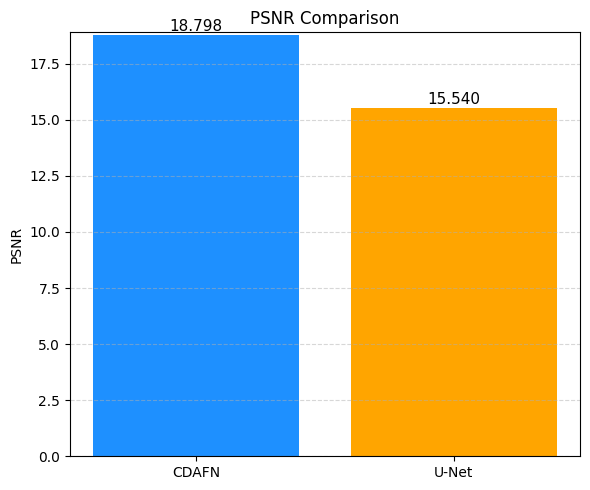

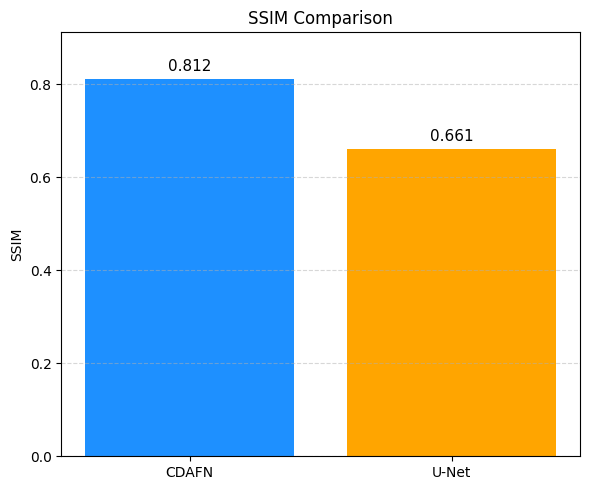

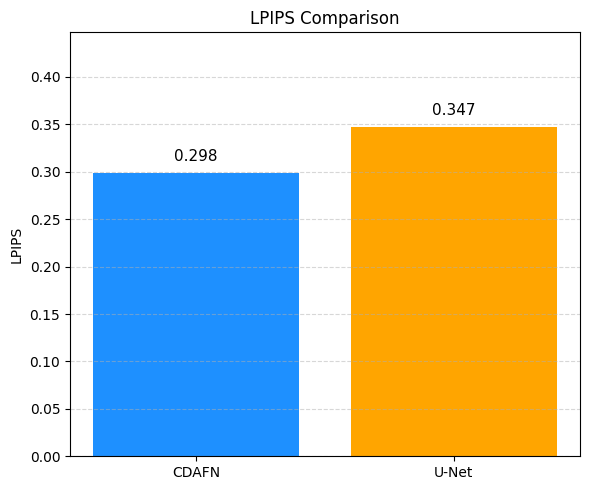

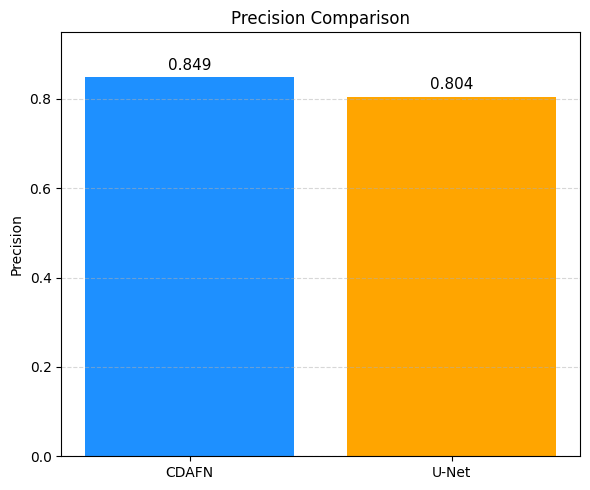

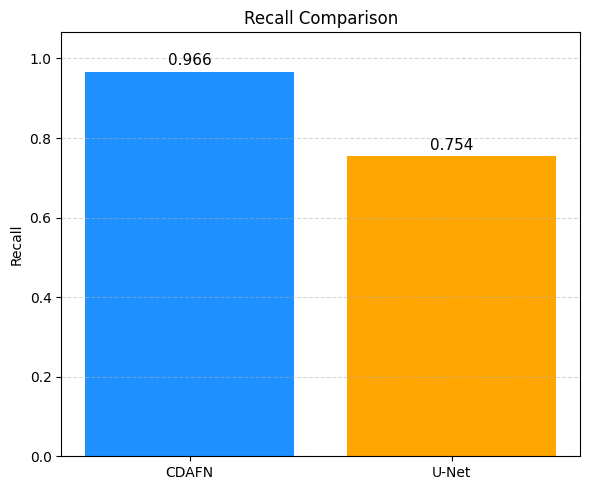

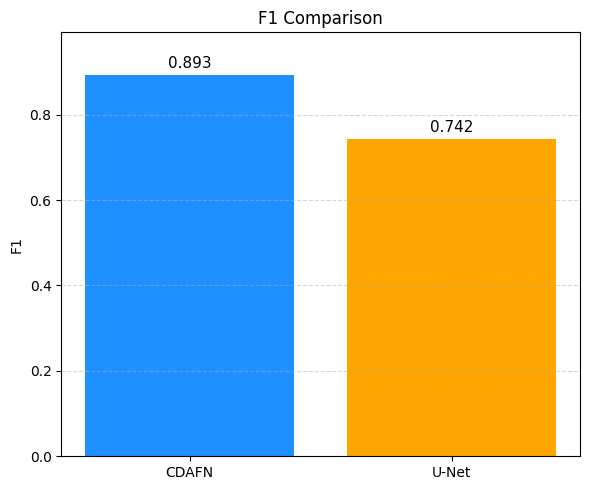

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("model_comparison_metrics.csv")

# Metrics
metrics = ["PSNR", "SSIM", "LPIPS", "Precision", "Recall", "F1"]
colors = ["dodgerblue", "orange"]

# Model-wise means
averages = {
    "CDAFN": [df[f"{m}_CDAFN"].mean() for m in metrics],
    "U-Net": [df[f"{m}_U-Net"].mean() for m in metrics]
}

# Plot each metric individually
for i, metric in enumerate(metrics):
    values = [averages["CDAFN"][i], averages["U-Net"][i]]

    plt.figure(figsize=(6, 5))
    plt.bar(["CDAFN", "U-Net"], values, color=colors)
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.ylim(0, max(values) + 0.1)

    # Optional: add value labels
    for j, val in enumerate(values):
        plt.text(j, val + 0.01, f"{val:.3f}", ha="center", va="bottom", fontsize=11)

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
